fix the issue that the bounds extend to left and right pass the magnet
vector between ending and beginning 0.4966776870923198 0.019983356372826964


/home/billy/Desktop/storageRing/storageRingOptimization/ParticleTracerLatticeClass.py:686: UserWarning: ENDING POINTS DOES NOT MEET WITH BEGINNING POINT. LATTICE IS NOT CLOSED
  warnings.warn('ENDING POINTS DOES NOT MEET WITH BEGINNING POINT. LATTICE IS NOT CLOSED')


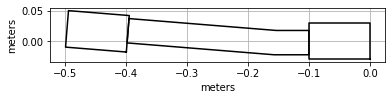

In [1]:
from ParticleClass import Particle
import skopt
from OptimizerClass import LatticeOptimizer
import dill
from ParticleTracerLatticeClass import ParticleTracerLattice
from SwarmTracerClass import SwarmTracer
from ParticleTracerClass import ParticleTracer
import time
import sys
import matplotlib.pyplot as plt
import numpy.linalg as npl
# parallel=True
# Lm,rp=[0.02248046875,0.008994140624999999]
PTL_Ring=ParticleTracerLattice(200.0,latticeType='storageRing')
# rOffsetFact=1.0#PTL_Ring.find_Optimal_Offset_Factor(rp,1.0,Lm,parallel=parallel)  #25% of time here, 1.0138513851385138
# PTL_Ring.add_Halbach_Lens_Sim(.01,.25)
PTL_Ring.add_Drift(.1)
PTL_Ring.add_Combiner_Sim('combinerData.txt')
PTL_Ring.add_Drift(.1)
# PTL_Ring.add_Halbach_Lens_Sim(.01,.25)
# PTL_Ring.add_Halbach_Bender_Sim_Segmented_With_End_Cap(Lm,rp,None,1.0,rOffsetFact=rOffsetFact)
# PTL_Ring.add_Halbach_Lens_Sim(.01,None,constrain=True)
# PTL_Ring.add_Halbach_Bender_Sim_Segmented_With_End_Cap(Lm,rp,None,1.0,rOffsetFact=rOffsetFact)
PTL_Ring.end_Lattice(enforceClosedLattice=False,constrain=False)  #17.8 % of time here
# file=open('ringFile','wb')
# dill.dump(PTL_Ring,file)
# file=open('ringFile','rb')
# PTL_Ring=dill.load(file)
PTL_Ring.show_Lattice()

In [2]:
particle=Particle()
particleTracer=ParticleTracer(PTL_Ring)
particle=particleTracer.trace(particle,1e-5,.1,fastMode=False)

1 0
2 1


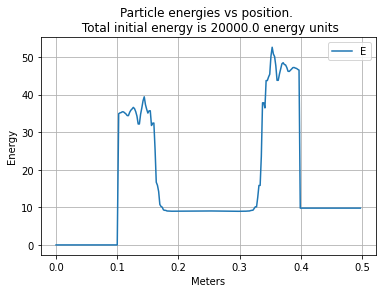

In [3]:
particle.plot_Energies(showOnlyTotalEnergy=True)

In [4]:
particle.elDeltaEDict

{'0': 0.0, '1': 11.601763116068469}

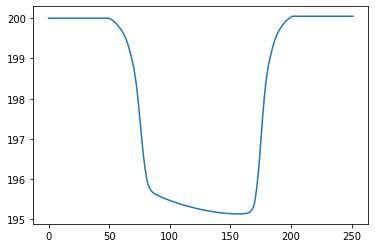

(200.04894805630155, 200.0)

In [5]:
v=npl.norm(particle.pArr,axis=1)
plt.plot(v)
plt.show()
v[-1],v[0]